<h1>CS4618: Artificial Intelligence I</h1>
<h1>Overfitting with Neural Networks</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from keras.datasets import mnist

from keras import Model
from keras import Input
from keras.layers import Rescaling
from keras.layers import Dense
from keras.layers import Dropout

from keras.optimizers import RMSprop

from keras.regularizers import l1
from keras.regularizers import l2

from keras.callbacks import EarlyStopping

In [3]:
# MNIST dataset

# Load MNIST into four Numpy arrays
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
mnist_x_train = mnist_x_train.reshape((60000, 28 * 28))
mnist_x_test = mnist_x_test.reshape((10000, 28 * 28))

<h1>Acknowledgement</h1>
<ul>
    <li>The analogy between dropout and a company whose employees are told to toss a coin to
        decide whether to go to work each morning comes from
        A. G&eacute;ron: <i>Hands-On Machine Learning with Scikit-Learn, Keras &amp;
        TensorFlow (2nd edn)</i>, O'Reilly, 2019
    </li>
</ul>

<h1>Introduction</h1>
<ul>
    <li>One of the central problems of deep learning is overfitting.</li>
    <li>Reminder. If your model overfits, your main options are:
        <ul>
            <li>gather more training examples;</li>
            <li>remove noise in the training examples;</li>
            <li>change model: move to a less complex model;</li>
            <li>simplify by reducing the number of features;</li>
            <li>stick with your existing model but
                add constraints (if you can) to reduce its complexity.
            </li>
        </ul>
    </li>
    <li>Here we'll look at
        <ul>
            <li>reducing the network's size &mdash; an example of moving to a less complex model;</li>
            <li>weight regularization &mdash; an example of adding constraints to reduce complexity;</li>
            <li>dropout &mdash; also an example of adding constraints to reduce complexity; and</li>
            <li>early stopping &mdash; a somewhat different way of avoiding overfitting.</li>
        </ul>
    </li>
</ul>

In [4]:
# A network that overfits (a little!)

inputs = Input(shape=(28 * 28,))
x = Rescaling(scale=1./255)(inputs)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
outputs = Dense(10, activation="softmax")(x)
overfitting_model = Model(inputs, outputs)
overfitting_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy")

In [5]:
history = overfitting_model.fit(mnist_x_train, mnist_y_train, epochs=20, batch_size=32, 
                                verbose=0, validation_split=0.20)
history.history["loss"][-1], history.history["val_loss"][-1]

(0.000628800829872489, 0.0988258495926857)

<Axes: >

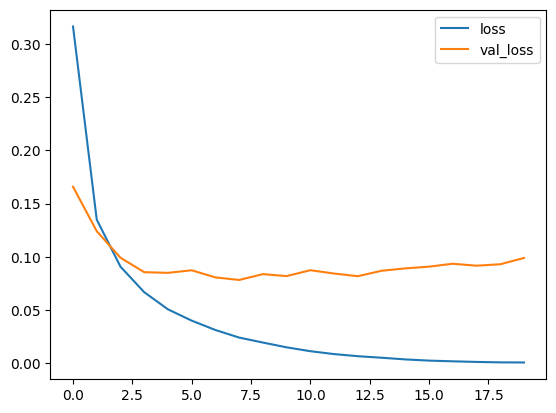

In [6]:
# Training curve
pd.DataFrame(history.history).plot()

<h1>Reducing Network Size</h1>
<ul>
    <li>We can make the model (neural network) less complex by reducing the number of parameters.</li>
    <li>Obviously enough, this is achieved by:
        <ul>
            <li>reducing the number of hidden layers, and/or</li>
            <li>reducing the number of neurons within the hidden layers.</li>
        </ul>
    </li>
</ul>

<h2>Example of reducing network size</h2>

In [7]:
# Smaller network

inputs = Input(shape=(28 * 28,))
x = Rescaling(scale=1./255)(inputs)
x = Dense(256, activation="relu")(x)
outputs = Dense(10, activation="softmax")(x)
smaller_model = Model(inputs, outputs)
smaller_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy")

In [8]:
history = smaller_model.fit(mnist_x_train, mnist_y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.2)
history.history["loss"][-1], history.history["val_loss"][-1]

(0.05574346333742142, 0.09492190182209015)

<h1>Weight Regularization</h1>
<ul>
    <li>For linear regression, we used <b>regularization</b> to ensure that the coefficients $\v{\beta}$ took only
        small values by penalizing large values in the loss function.
        <ul>
            <li>Lasso: we penalized by the $\cal{l}_1$-norm (the sum of their absolute values).
            </li>
            <li>Ridge: we penalized by the $\cal{l}_2$-norm (the sum of their squares).
            </li>
            <li>A hyperparameter $\lambda$, called the 'regularization parameter' controlled the balance 
                between fitting the data versus shrinking the parameters.
            </li>
        </ul>
    </li>
    <li>Weight Regularization in neural networks is the same idea, but applied to the weights 
        in the layers of a network.
    </li>
</ul>

In [9]:
# Regularized network

inputs = Input(shape=(28 * 28,))
x = Rescaling(scale=1./255)(inputs)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001))(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001))(x)
outputs = Dense(10, activation="softmax", kernel_regularizer=l2(0.0001))(x)
regularized_model = Model(inputs, outputs)
regularized_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy")

In [10]:
history = regularized_model.fit(mnist_x_train, mnist_y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.2)
history.history["loss"][-1], history.history["val_loss"][-1]

(0.059254053980112076, 0.11476939171552658)

<ul>
    <li>Weight regularization can work well when the network is small but has little effect on larger networks.</li>
    <li>For larger networks, a better option can be <i>dropout</i>.</li>
</ul>

<h1>Dropout</h1>
<ul>
    <li>Imagine we have a layer that uses <b>dropout</b> with <b>dropout rate</b> $p$, e.g. $p=0.5$.</li>
    <li>Then, in a given step of the backprop algorithm, each neuron in the layer has
        probability $p$ of being ignored &mdash; treated as if it were not there.
        <figure>
            <img src="images/dropout.png" />
        </figure>
    </li>
</ul>

<h2>One way of doing dropout</h2>
<ul>
    <li>Suppose the dropout rate is $p$.
    <li>Training. For any given mini-batch:
        <ul>
            <li>In the forward propagation, 
                <ul>
                    <li>decide which neurons will be dropped (chosen with probability $p$);</li>
                    <li>set the activations of the dropped neurons to zero;</li>
                    <li>multiply the activations of the kept neurons by $1 / (1 - p)$.</li>
                </ul>
            </li>
            <li>In the backpropagation, ignore the dropped out neurons.</li>
        </ul>
        Note that different neurons will get dropped for each mini-batch.
    </li>
    <li>Testing. No change.</li>
    <li>But why did we multiply activations by $1/ (1 - p)$?
        <ul>
            <li>In testing, for $p=0.5$ a neuron in the next layer will receive input from on average
                twice as many neurons as it did in training.
            </li>
            <li>The multiplication by $1/(1 - p)$ compensates for this.
            </li>
        </ul>
    </li>
</ul>

<h2>Why does dropout reduce overfitting?</h2>
<ul>
    <li>Consider a company whose employees were told to toss a coin every monring to decide
        whether to go to work or not.
        <ul>
            <li>The organization would need to become more resilient. It could not rely on any
                one employee to perform critical tasks: the expertise would need to be spread
                across many employees. They must become more like generalists, less like specialists.
            </li>
        </ul>
        Similarly, in dropout layers, neurons learn more robust features.     
    </li>
    <li>Another way to think about it.
        <ul>
            <li>Since a neuron can be present or absent, it's like training on a different neural
                network at each step.
            </li>
            <li>The final result is  a bit like an ensemble of these many different virtual
                neural networks.
            </li>
        </ul>
    </li>
    <li>However, it typically increases the number of epochs needed for convergence
        (roughly double when $p=0.5$).
    </li>
</ul>

<h2>Dropout in Keras</h2>

In [11]:
# Network with dropout

inputs = Input(shape=(28 * 28,))
x = Rescaling(scale=1./255)(inputs)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation="softmax")(x)
model_with_dropout = Model(inputs, outputs)
model_with_dropout.compile(optimizer=RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy")

In [12]:
history = model_with_dropout.fit(mnist_x_train, mnist_y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.2)
history.history["loss"][-1], history.history["val_loss"][-1]

(0.04355981573462486, 0.08280795812606812)

<h1>Early Stopping</h1>
<ul>
    <li>We know that a sign of overfitting is that validation error stops getting lower and starts
        getting larger.
    </li>
    <li>We can exploit this <em>during</em> Gradient Descent as another way of avoiding overfitting,
        known as <b>early stopping</b>:
        <ul>
            <li>During Gradient Descent, monitor validation error (or loss).</li>
            <li>Interrupt training when the validation error has stopped improving for a certain number
                of epochs.
            </li>
        </ul>
    </li>
</ul>

<h2>Early stopping in Keras</h2>
<ul>
    <li>In Keras, this is done using the <code>EarlyStopping</code> callback.</li>
    <li>The <code>patience</code> argument allows you to specify how many epochs must pass with
        no improvement relative to the current best.
    </li>
    <li><code>restore_best_weights=True</code> restores the weights and biases from when validation
        error was at its lowest.
    </li>
</ul>

In [13]:
history = overfitting_model.fit(mnist_x_train, mnist_y_train, epochs=20, batch_size=32, 
                                verbose=0, validation_split=0.2, 
                                callbacks=[EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)])

In [14]:
[(l, v) for l, v in zip(history.history["loss"], history.history["val_loss"])]

[(0.0003599048941396177, 0.09593457728624344),
 (0.0002880418032873422, 0.09756484627723694),
 (0.0002400884695816785, 0.09810171276330948)]

<ul>
    <li>An advantage of early stopping is that we can be less concerned about choosing the number of
        epochs: just use something very large.
    </li>
    <li>But, now we have the problem of deciding on the patience. If run-time is your problem, then
        you can choose a low value. Otherwise, you should choose a low value for 'easier' problems!
    </li>
</ul>

<h1>Conclusions</h1>
<ul>
    <li>Overfitting is a major problem but has many solutions.</li>
    <li>There are lots of solutions in additon to the ones above:
        <ul>
            <li>Remember Batch Normalization has a regularizing effect.</li>
            <li>There are other techniques that we won't cover (e.g. clipping).</li>
            <li>There are the things we've mentioned in an earlier lecture, especially getting more data!</li>
        </ul>
    </li>
</ul>

<h1>Appendix</h1>
<h2>Over-parameterisation</h2>
<ul>
    <li>Our discussion so far of overfitting in neural networks follows the conventional viewpoint: on a small network, validation error is high (underfitting); as we increase complexity (e.g. more layers), then validation error decreases but, after a certain point, it starts to rise again (overfitting).</li>
    <li>In fact, with deep learning, we are finding something counter-intuitive. If we keep increasing the complexity, then validation error decreases again, falling to a new minimum. This is called <b>double descent</b>. (See <a href="https://mlu-explain.github.io/double-descent/">this visualisation</a>, if you're interested.)</li>
    <li>We are finding this happens with over-parameterized models &mdash; ones that are excessively complex. Neural networks with many neurons are the obvious examples of this. But we can even have linear models that are overparameterized.
    <li>When the model is over-parameterised, it fits the training data (near) perfectly (even the noise). We would expect an overparameterized model to have poor performance on unseen data (overfitting).  But, we find that the model seems to generalise well to unseen data. What's going on?</li>
    <li>We don't really know. But the current theory, in high-level terms, is that the over-parameterised model makes smoother interpolations between the training examples, and this is what gives the better validation error. (See <a href="https://mlu-explain.github.io/double-descent2/">this explanation</a>, if you're interested.)</li>
    <!--<li>It is also fairly easy to avoid double descent: using the regularization or dropout techniques described in the next lecture.</li>-->
</ul>